In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load a pretrained model

This was train with 2 convolutions layers for a coloured image

In [2]:
model1 = tf.keras.models.load_model("./checkpoints/esp32/")

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2023-04-26 14:35:35.480621: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-26 14:35:35.480755: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# First step build a loss function

The idea is to maximize the activation

In [3]:
def loss(prediction, initial_random_image):
    """
        initial_random_image: initial random image made to max out the activation of the filter.
        prediction: output of the filter's activation.
        Squared Error
    """

    return tf.math.sqrt(tf.math.square(tf.math.subtract(prediction, initial_random_image)))

In [4]:
y_pred = tf.constant(2, dtype="float32")
y = tf.constant(5, dtype="float32")
samples = tf.constant(2, dtype="float32")

In [5]:
loss(y_pred, y)/samples

<tf.Tensor: shape=(), dtype=float32, numpy=1.5>

# Generate a random image

In [6]:
random_initial_image = np.abs(np.random.RandomState(444).normal(0, 1, (256, 256, 3)))

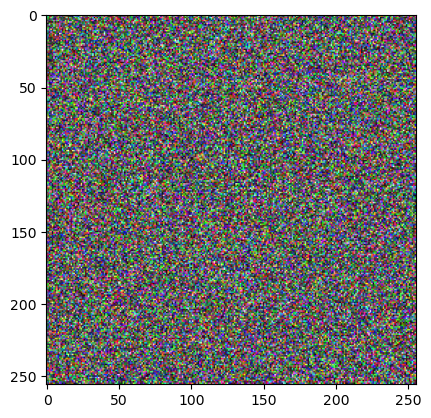

In [7]:
random_initial_image *=127
random_initial_image = random_initial_image.clip(min=0, max=255).astype("uint8")
plt.imshow(random_initial_image)

In [8]:
# Get a filter from a model to build a new one with that only filter 

In [9]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 1st_conv_3x3 (Conv2D)       (None, 254, 254, 4)       112       
                                                                 
 1st_max_pooling (MaxPooling  (None, 127, 127, 4)      0         
 2D)                                                             
                                                                 
 2nd_conv_3x3 (Conv2D)       (None, 125, 125, 8)       296       
                                                                 
 features_vector (GlobalMaxP  (None, 8)                0         
 ooling2D)                                                       
                                                                 
 sigmoid_output (Dense)      (None, 1)                 9     

In [10]:
# model1 = tf.keras.models.load_model("../robotics/detect_cat_light_led/notebooks/checkpoints/esp32/")

In [11]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 1st_conv_3x3 (Conv2D)       (None, 254, 254, 4)       112       
                                                                 
 1st_max_pooling (MaxPooling  (None, 127, 127, 4)      0         
 2D)                                                             
                                                                 
 2nd_conv_3x3 (Conv2D)       (None, 125, 125, 8)       296       
                                                                 
 features_vector (GlobalMaxP  (None, 8)                0         
 ooling2D)                                                       
                                                                 
 sigmoid_output (Dense)      (None, 1)                 9     

In [12]:
layer = model1.get_layer(name="1st_conv_3x3")

In [13]:
layer.get_config()

{'name': '1st_conv_3x3',
 'trainable': True,
 'dtype': 'float32',
 'filters': 4,
 'kernel_size': (3, 3),
 'strides': (1, 1),
 'padding': 'valid',
 'data_format': 'channels_last',
 'dilation_rate': (1, 1),
 'groups': 1,
 'activation': 'relu',
 'use_bias': True,
 'kernel_initializer': {'class_name': 'GlorotUniform',
  'config': {'seed': None}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

In [14]:
kernels = layer.get_weights()[0]
bias = layer.get_weights()[1]

In [15]:
np.save("first_set_of_filters_kernels.npy", kernels)
np.save("first_set_of_filters_bias.npy", bias)

In [16]:
# What is this ? Should it be (3, 3, 4)? four kernels of 3 by 3?
kernels.shape

(3, 3, 3, 4)

In [17]:
kernels[:, :, 0, 0]

array([[-0.07846514, -0.10964727, -0.29045194],
       [-0.5967758 , -0.08404627, -0.21201545],
       [ 0.18586797, -0.19563708, -0.37379047]], dtype=float32)

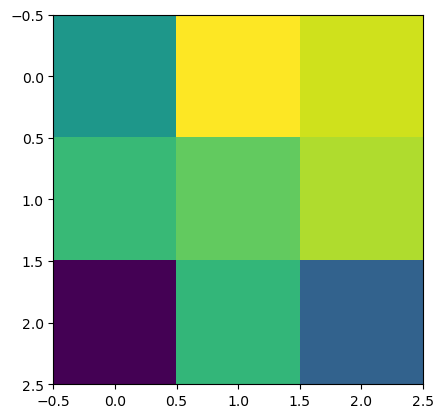

In [18]:
filter_sample = (kernels[:, :, 0, 3]*64)+128
filter_sample = filter_sample.clip(0, 255).astype("uint8")
plt.imshow(filter_sample)

In [19]:
#(3, 3, 3, 4)

#first 2 are the kernel size
# third is the input channels
# last is the output channels

kernels.shape

(3, 3, 3, 4)

# First 3 kernels out of 4

We seems to have 3 sets of 4 kernels one per each channel

In [20]:
#will go from 0 to 3
kernel_index=0

kernels[:, :, :, kernel_index]

array([[[-0.07846514,  0.43229765, -0.41011247],
        [-0.10964727,  0.04637174, -0.09879821],
        [-0.29045194,  0.26057553,  0.19170508]],

       [[-0.5967758 ,  0.11136737, -0.51537365],
        [-0.08404627,  0.5394609 ,  0.09264313],
        [-0.21201545,  0.25564024,  0.1623198 ]],

       [[ 0.18586797,  0.584597  , -0.01415573],
        [-0.19563708,  0.59923476,  0.02847724],
        [-0.37379047,  0.6332132 , -0.25659934]]], dtype=float32)

# Our random image 

In [21]:
random_initial_image = np.expand_dims(random_initial_image, axis=0)

In [22]:
#Channel 1

random_initial_image[0][:3, :3, 0]

array([[ 45, 149,  68],
       [ 38,  16, 125],
       [ 47,  38, 112]], dtype=uint8)

In [23]:
#Channel 2

random_initial_image[0][:3, :3, 1]

array([[ 47, 119,  69],
       [101, 255,  23],
       [155, 192, 116]], dtype=uint8)

In [24]:
#Channel 3

random_initial_image[0][:3, :3, 2]

array([[175, 145,  26],
       [164, 117,  71],
       [193,  48,   6]], dtype=uint8)

In [25]:
bias

array([0.28339198, 0.01648722, 0.56667376, 0.06486207], dtype=float32)

In [26]:
total_convolution = 0
filter_number = 0

for channel in range(3):
    position_by_position_multiplication = kernels[:, :, channel, filter_number]*random_initial_image[0][:3, :3, channel]
    convolution_result = position_by_position_multiplication.sum()
    print(position_by_position_multiplication)
    print(convolution_result)
    print("----------------------------------")
    total_convolution+=convolution_result

print(f"Results: {round(total_convolution+bias[0], 5)}")

[[ -3.5309315 -16.337442  -19.750732 ]
 [-22.67748    -1.3447403 -26.501932 ]
 [  8.735794   -7.434209  -41.864532 ]]
-130.7062
----------------------------------
[[ 20.31799     5.5182366  17.979712 ]
 [ 11.248105  137.56253     5.8797255]
 [ 90.61253   115.05307    73.452736 ]]
477.6246
----------------------------------
[[-71.769684  -14.32574     4.984332 ]
 [-84.52128    10.839246   11.524705 ]
 [ -2.7320552   1.3669076  -1.5395961]]
-146.17317
----------------------------------
Results: 201.02862


# Make a new model only with the first layer of kernels

In [27]:
new_model = tf.keras.Model(inputs=model1.input, outputs=layer.output)

In [28]:
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 1st_conv_3x3 (Conv2D)       (None, 254, 254, 4)       112       
                                                                 
Total params: 112
Trainable params: 112
Non-trainable params: 0
_________________________________________________________________


In [76]:
# run the new model on the first layer of filters which is 4 sets of 3 filters.

activation = new_model(random_initial_image/255).numpy()[0]

In [77]:
np.save("reference_activation_maps_first_layer.npy", activation)

In [31]:
round(activation[0, 0, 0], 5)

201.02866

In [32]:
total_convolution = 0
filter_number = 0

for channel in range(3):
    print(f"channel: {channel}")
    position_by_position_multiplication = kernels[:, :, channel, filter_number]*random_initial_image[0][0:3, 1:4, channel]
    convolution_result = position_by_position_multiplication.sum()
    print(position_by_position_multiplication)
    print(convolution_result)
    print("----------------------------------")
    total_convolution+=convolution_result

print(f"Results: {round(total_convolution+bias[0], 5)}")

channel: 0
[[-11.691306   -7.456014   -7.8422027]
 [ -9.548413  -10.505783  -38.374798 ]
 [  7.0629826 -21.911352  -78.86979  ]]
-179.13667
----------------------------------
channel: 1
[[ 51.44342     3.1996498  41.95266  ]
 [ 28.39868    12.4076      1.7894816]
 [112.24262    69.51123   115.87802  ]]
436.82336
----------------------------------
channel: 2
[[-59.46631     -2.5687535   19.553919  ]
 [-60.298717     6.577662     5.356553  ]
 [ -0.6794749    0.17086345 -45.418083  ]]
-136.77234
----------------------------------
Results: 121.19774


# The same result of the convolution by hand

In [33]:
activation[0, 1, 0]

121.19774

In [34]:
random_initial_image[0][0:3, 1:4, 0]

array([[149,  68,  27],
       [ 16, 125, 181],
       [ 38, 112, 211]], dtype=uint8)

In [35]:
random_initial_image[0][0:3, 0:3, 0]

array([[ 45, 149,  68],
       [ 38,  16, 125],
       [ 47,  38, 112]], dtype=uint8)

In [36]:
random_initial_image[0][:,:,0]

array([[ 45, 149,  68, ...,  54,  77,  49],
       [ 38,  16, 125, ..., 123,  85, 221],
       [ 47,  38, 112, ..., 119,  44, 135],
       ...,
       [  7,  37, 113, ..., 105,  65, 128],
       [ 89,  33, 119, ..., 106, 120,  78],
       [255,  13, 255, ...,  43,  33, 112]], dtype=uint8)

In [37]:
new_activations = np.zeros((254, 254, 4))

In [38]:
new_activations.shape

(254, 254, 4)

In [39]:
def relu(x):
    return 0 if x<0 else x

In [40]:
relu(89)

89

In [41]:
relu(-19)

0

In [42]:
activation.shape

(254, 254, 4)

In [43]:
kernels.shape

(3, 3, 3, 4)

# Apply a complete convolution operation

In [44]:
class NaiveConv2D():
    def __init__(self, kernels, bias, kernel_size, channels_count, filters_count, stride):
        self.kernels=kernels
        self.bias= bias
        self.kernel_size=kernel_size
        self.channels_count=channels_count
        self.filters_count=filters_count
        self.stride=stride

    def __call__(self, feature_map):
        map_size = feature_map.shape
        new_w=(map_size[0]-self.kernel_size+1)//self.stride
        new_h=(map_size[1]-self.kernel_size+1)//self.stride

        new_activations = np.zeros((new_w, new_h, self.filters_count), dtype="float32")

        for filter_index in range(self.filters_count):
            for i in range(0, map_size[0]-self.kernel_size+1, self.stride):
                for j in range(0, map_size[0]-self.kernel_size+1, self.stride):
                    total_convolution = 0
                    for channel_index in range(self.channels_count):
                        position_by_position_multiplication = self.kernels[:, :, channel_index, filter_index]*feature_map[i:i+self.kernel_size, j:j+self.kernel_size, channel_index]
                        total_convolution += position_by_position_multiplication.sum()
                    new_activations[i, j, filter_index] = relu(total_convolution+bias[filter_index])
        
        return new_activations

In [45]:
new_activations = NaiveConv2D(kernels, bias, 3, 3, 4, 1)(random_initial_image[0]/255)

In [46]:
activations = new_model(random_initial_image/255).numpy()[0]

In [47]:
new_activations[:, :, 2]

array([[1.8546033 , 1.7361648 , 1.3187243 , ..., 1.4495012 , 1.5984406 ,
        1.8592799 ],
       [1.7060473 , 1.4130031 , 1.7605685 , ..., 1.6453943 , 1.6331444 ,
        1.2321002 ],
       [1.3868461 , 0.74222916, 1.6050011 , ..., 1.7831709 , 1.494614  ,
        1.6528127 ],
       ...,
       [2.1192784 , 1.80885   , 1.2951792 , ..., 1.8351628 , 2.1538367 ,
        1.5477519 ],
       [1.3886362 , 1.640524  , 1.7976015 , ..., 1.53851   , 1.6374114 ,
        1.5598892 ],
       [1.9323611 , 1.0343285 , 1.7974187 , ..., 1.8709366 , 1.9126283 ,
        1.1660706 ]], dtype=float32)

In [48]:
activations[:, :, 2]

array([[1.8546033 , 1.7361648 , 1.3187243 , ..., 1.449501  , 1.5984406 ,
        1.8592799 ],
       [1.7060474 , 1.4130031 , 1.7605686 , ..., 1.6453944 , 1.6331444 ,
        1.2321004 ],
       [1.3868461 , 0.74222916, 1.6050011 , ..., 1.7831709 , 1.494614  ,
        1.6528128 ],
       ...,
       [2.1192784 , 1.80885   , 1.2951794 , ..., 1.8351629 , 2.1538367 ,
        1.5477519 ],
       [1.3886361 , 1.640524  , 1.7976015 , ..., 1.5385101 , 1.6374115 ,
        1.5598892 ],
       [1.9323614 , 1.0343285 , 1.7974186 , ..., 1.8709366 , 1.9126283 ,
        1.1660707 ]], dtype=float32)

In [49]:
(activations[:, :, 0] - new_activations[:, : ,0]).sum()

0.00041151544

In [50]:
(activations[:, :, 1] - new_activations[:, : ,1]).sum()

0.00012794923

In [51]:
(activations[:, :, 2] - new_activations[:, : ,2]).sum()

0.0014592409

In [52]:
(activations[:, :, 3] - new_activations[:, : ,3]).sum()

0.0007924373

In [53]:
#Total parameters

256*256*3

196608

In [54]:
# first layers of filters

#Kernel size each has 9 learneable parameters, then we have 4 groups of 3 filters each per channel and the 4 parameters for the bias

3*3 * 3 * 4 + 4

112

In [55]:
# so instead of flattering the image and use a dense network with x lets say 1024 parameters we avoid having a huge matrix of  [196608, 1024] + [1024] parameters 

# improve performance

In [56]:
(kernels[:3, :3, :, 0] * random_initial_image[0][:3, 1:4, :]).sum()

120.914345

In [57]:
activations[0, 1, 0]

0.757566

In [58]:
class ImproveNaiveConv2D():
    """ 
        Multiply all channels at once on that location
    """
    def __init__(self, kernels, bias, kernel_size, channels_count, filters_count, stride):
        self.kernels=kernels
        self.bias= bias
        self.kernel_size=kernel_size
        self.channels_count=channels_count
        self.filters_count=filters_count
        self.stride=stride

    def __call__(self, feature_map):
        map_size = feature_map.shape
        new_w=(map_size[0]-self.kernel_size+1)//self.stride
        new_h=(map_size[1]-self.kernel_size+1)//self.stride

        new_activations = np.zeros((new_w, new_h, self.filters_count), dtype="float32")

        for filter_index in range(self.filters_count):
            for i in range(0, map_size[0]-self.kernel_size+1, self.stride):
                for j in range(0, map_size[0]-self.kernel_size+1, self.stride):
                    position_by_position_multiplication = self.kernels[:, :, :, filter_index]*feature_map[i:i+self.kernel_size, j:j+self.kernel_size, :]
                    new_activations[i, j, filter_index] = relu(position_by_position_multiplication.sum()+bias[filter_index])
        
        return new_activations

In [59]:
new_improve_activations = ImproveNaiveConv2D(kernels, bias, 3, 3, 4, 1)(random_initial_image[0]/255)

In [60]:
(activations-new_improve_activations).sum()

0.0027912662

In [61]:
(activations-new_activations).sum()

0.0027911433

In [62]:
(new_activations-new_improve_activations).sum()

1.2293458e-07

# Tensorflow migration BUG WITH METAL PLUGIN

In [63]:
input_variable_tensor = tf.Variable(random_initial_image, dtype="float32")
kernels_tensor = tf.Variable(kernels, dtype="float32")
bias_tensor = tf.Variable(bias, dtype="float32")

In [64]:
%%time

kernels_tensor[:3, :3, :, 0]*input_variable_tensor[0][:3, :3, :]

CPU times: user 10.1 ms, sys: 2 ms, total: 12.1 ms
Wall time: 9.9 ms


<tf.Tensor: shape=(3, 3, 3), dtype=float32, numpy=
array([[[ -3.5309315,  20.31799  , -71.769684 ],
        [-16.337442 ,   5.5182366, -14.32574  ],
        [-19.750732 ,  17.979712 ,   4.984332 ]],

       [[-22.67748  ,  11.248105 , -84.52128  ],
        [ -1.3447403, 137.56253  ,  10.839246 ],
        [-26.501932 ,   5.8797255,  11.524705 ]],

       [[  8.735794 ,  90.61253  ,  -2.7320552],
        [ -7.434209 , 115.05307  ,   1.3669076],
        [-41.864532 ,  73.452736 ,  -1.5395961]]], dtype=float32)>

In [65]:
kernels_tensor[:3, :3, :, 0]*input_variable_tensor[0][:3, :3, :]

<tf.Tensor: shape=(3, 3, 3), dtype=float32, numpy=
array([[[ -3.5309315,  20.31799  , -71.769684 ],
        [-16.337442 ,   5.5182366, -14.32574  ],
        [-19.750732 ,  17.979712 ,   4.984332 ]],

       [[-22.67748  ,  11.248105 , -84.52128  ],
        [ -1.3447403, 137.56253  ,  10.839246 ],
        [-26.501932 ,   5.8797255,  11.524705 ]],

       [[  8.735794 ,  90.61253  ,  -2.7320552],
        [ -7.434209 , 115.05307  ,   1.3669076],
        [-41.864532 ,  73.452736 ,  -1.5395961]]], dtype=float32)>

In [66]:
%%time
result = tf.keras.activations.relu(tf.math.reduce_sum(tf.math.multiply(kernels_tensor[:3, :3, :, 0], input_variable_tensor[0][:3, :3, :]))+bias_tensor[0])

CPU times: user 14 ms, sys: 2.61 ms, total: 16.6 ms
Wall time: 14.7 ms


In [67]:
%%time
result = tf.math.reduce_sum(tf.math.multiply(kernels_tensor[:3, :3, :, 0], input_variable_tensor[0][:3, :3, :]))+bias_tensor[0]

CPU times: user 2.07 ms, sys: 883 µs, total: 2.96 ms
Wall time: 1.95 ms


In [68]:
class TFImprovedNaiveConv2D():
    """ 
        Multiply all channels at once on that location
    """
    def __init__(self, kernels, bias, kernel_size, channels_count, filters_count, stride):
        self.kernels=kernels
        self.bias=bias
        self.kernel_size=kernel_size
        self.channels_count=channels_count
        self.filters_count=filters_count
        self.stride=stride
        self.output=[]
        self.new_w=None
        self.new_h=None

    @tf.function
    def __call__(self, feature_map):
        map_size = feature_map.shape

        self.new_w=(map_size[0]-self.kernel_size+1)//self.stride
        self.new_h=(map_size[1]-self.kernel_size+1)//self.stride

        states = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True, clear_after_read=False)

        linear_index = 0
        for filter_index in tf.range(tf.constant(self.filters_count)):
            for i in tf.range(tf.constant(0), tf.constant(map_size[0]-self.kernel_size+1), tf.constant(self.stride)):
                for j in tf.range(tf.constant(0), tf.constant(map_size[1]-self.kernel_size+1), tf.constant(self.stride)):
                    states = states.write(linear_index,
                        tf.keras.activations.relu(
                            tf.math.add(
                                tf.math.reduce_sum(
                                    tf.math.multiply(self.kernels[:, :, :, filter_index], feature_map[i:i+tf.constant(self.kernel_size), j:j+tf.constant(self.kernel_size), :])
                                )
                                ,self.bias[filter_index]
                            )
                        )
                    )
                    linear_index+=1

        return tf.reshape(states.stack(), shape=(self.new_h, self.new_w, self.filters_count))

In [69]:
for i in tf.range(tf.constant(9)):
    print(i)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)


In [70]:
input_variable_tensor = tf.Variable(random_initial_image, dtype="float32")
kernels_tensor = tf.Variable(kernels, dtype="float32")
bias_tensor = tf.Variable(bias, dtype="float32")

In [71]:
kernels_tensor.shape

TensorShape([3, 3, 3, 4])

In [72]:
kernels_tensor[:,:,:,tf.constant(2)]

<tf.Tensor: shape=(3, 3, 3), dtype=float32, numpy=
array([[[ 0.16435136, -0.17349781,  0.16558672],
        [ 0.33864316,  0.16800511,  0.26421213],
        [-0.5373103 , -0.15138781,  0.01899409]],

       [[ 0.12416938,  0.06041023,  0.49908152],
        [ 0.2141808 ,  0.13906431,  0.09751511],
        [ 0.22041571,  0.24957758,  0.00432114]],

       [[ 0.37535784,  0.05925759, -0.06526779],
        [-0.3072902 ,  0.04028831,  0.02660448],
        [ 0.03257824,  0.38588667,  0.23131306]]], dtype=float32)>

# Comparison vs naive improve implementation with Numpy

In [73]:
%%time
with tf.device("/cpu:0"):
    custom_conv_layer = TFImprovedNaiveConv2D(kernels_tensor, bias_tensor, 3, 3, 4, 1)
    tf_results = custom_conv_layer(input_variable_tensor[0]/255)

2023-04-26 14:35:40.612795: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-26 14:35:40.613335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


CPU times: user 1min 14s, sys: 50.6 s, total: 2min 5s
Wall time: 1min 22s


In [74]:
%%time
new_improve_activations = ImproveNaiveConv2D(kernels, bias, 3, 3, 4, 1)(random_initial_image[0]/255)

CPU times: user 653 ms, sys: 15.8 ms, total: 668 ms
Wall time: 672 ms


In [75]:
(tf_results.numpy()-new_improve_activations).sum()

0.003540039

# Conclution

Numpy implementation is still better in performance...